In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from IPython.display import Markdown as md
from slugify import slugify

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

a_property =  {'color' : 'red'}

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df
def add_labels_display(data, column_name, labels):
    # Changes column values from integer to labels and sets df.index to column_name
    data[column_name] = data[column_name].apply(lambda x: labels[x])
    data.set_index(column_name, drop=True, inplace=True)
    data.index.name = None
        
    return data.style.format(precision=2).set_table_styles(table_css_styles)
def normalize_column(x):
    return (x - x.min())/(x.max()-x.min())

def attribute_summary(some_data, vals, voi, columns: dict = None, labels: dict = None):
    
    groupby = ['echantillon', voi]
    
    data = some_data.groupby(groupby, as_index=False)[vals].sum()
    data[voi] = data[voi].apply(lambda x: labels[x])

    data_summary = data.groupby(voi, as_index=False)[vals].describe()
    data_summary[['count', 'max', 'min']] = data_summary[['count', 'max', 'min']].astype('int')
    data_summary.rename(columns=columns, inplace=True)
    data_summary.set_index(voi, inplace=True, drop=True)
    data_summary.index.name = None
    
    select_values = data_summary["moyenne"] > 1.45
    test_one = data_summary.loc[select_values].index
    
    select_values = data_summary["50%"] > .78
    test_two = data_summary.loc[select_values].index
        
    d_sum = data_summary.style.set_table_styles(table_css_styles).format(precision=2)
    d_sum = d_sum.set_properties(subset = pd.IndexSlice[test_one,["moyenne"]], **a_property)
    
    return d_sum.set_properties(subset = pd.IndexSlice[test_two,["50%"]], **a_property)

def attribute_summary_grid(data, vals, voi, labels: dict=None, stat="probability"):
    
    groupby = ['date', voi]
    some_data = data.groupby(groupby, as_index=False)[vals].sum()
    some_data[voi] = some_data[voi].apply(lambda x: labels[x])
    
    fig, axs = plt.subplots(2,2, figsize=(8,7))

    sns.scatterplot(some_data,x="date", y=vals, hue=voi,  ax=axs[0,0])
    sns.boxplot(some_data, x=voi, y=vals, hue=voi, showfliers=False, ax=axs[1,0], dodge=False)
    sns.histplot(some_data,x=vals, hue=voi, ax=axs[0,1], stat=stat)
    sns.ecdfplot(some_data, x=vals, hue=voi, ax=axs[1,1])
    # axs[0,0].set_ylim(-1, 1000)
    # axs[0,1].set_xlim(-1, 1000)
    # axs[1,1].set_xlim(-1, 1000)
    axs[0,0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    axs[0,0].set_xlabel("échantillon")
    axs[0,0].set_ylabel("particules")
    axs[0,0].get_legend().remove()
    axs[1,0].get_legend().remove()
    axs[1,0].set_xlabel("")
    axs[1,0].set_ylabel("particules")
    axs[0,1].set_xlabel("")
    axs[0,1].set_ylabel("probabilité")
    axs[1,0].tick_params(axis="x", rotation=90, )
    axs[1,1].get_legend().remove()
    axs[1,1].set_xlabel("")
    plt.subplots_adjust(wspace=.3)

    plt.tight_layout
    plt.show()


new_data = pd.read_csv("data/macro_current.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")
n_beach_data = pd.read_csv("data/pstock_beaches_current.csv")

# Macro : plage et attribut

## Substrat

In [2]:
new_data = new_data.merge(beach_data[["Plage", "frequentation", "situation", "distance", "orientation"]], left_on = "Plage", right_on="Plage")

new_column_names = {
    "Position":"position",
    "Substrat":"substrat",
    "Date":"date",
    "Code":"code",
    "Quantité":"quantite",
    "Aire":"area"
}

variables = ["position", "substrat", "frequentation", "situation", "distance", "orientation"]

length_key = n_beach_data[["Plage","length"]].drop_duplicates("Plage").set_index("Plage")
work_data = new_data[["Plage",  'frequentation', 'situation', 'distance', 'orientation', *new_column_names.keys()]].copy()
work_data.rename(columns=new_column_names, inplace=True)
work_data["length"] = work_data.Plage.apply(lambda x: length_key.loc[x, "length"])
work_data["slug"] = work_data.Plage.apply(lambda x: slugify(x))
work_data["echantillon"] = list(zip(work_data.slug, work_data['date']))
work_data['date'] = pd.to_datetime(work_data["date"], format="mixed", dayfirst=True)
work_data.dropna(inplace=True)
work_data[variables[:-1]] = work_data[variables[:-1]].astype("int")
work_data["pcs/m2"] = work_data.quantite/work_data.area

In [3]:
columns = ['Plage', 'echantillon', 'orientation', 'position', 'substrat','frequentation', 'situation', 'distance', "fibres", "fdure", "souple", "fragments", "added"]
column_display = {
    "count":"n échantillons",
    "mean": "moyenne",
    "std": "écart type",
    "echantillon":"échantillon"
}

# ananlysis of substrat
voi = "substrat"
vals = "pcs/m2"
groupbys = ['echantillon', voi]
labels = name_the_substrate

event_total = work_data.groupby(["echantillon", "Plage","date", voi], as_index=False)[vals].sum()


substrat_summary = attribute_summary(event_total, vals, voi, columns=column_display, labels=name_the_substrate)
substrat_summary

,n échantillons,moyenne,écart type,min,25%,50%,75%,max
galet,36,1.13,1.05,0,0.28,0.61,1.92,3
gravier,16,0.62,0.63,0,0.20,0.46,0.64,2
sable fin,27,2.59,2.44,0,0.91,1.56,4.37,8
sable grosssier,31,0.69,0.82,0,0.29,0.40,0.63,3


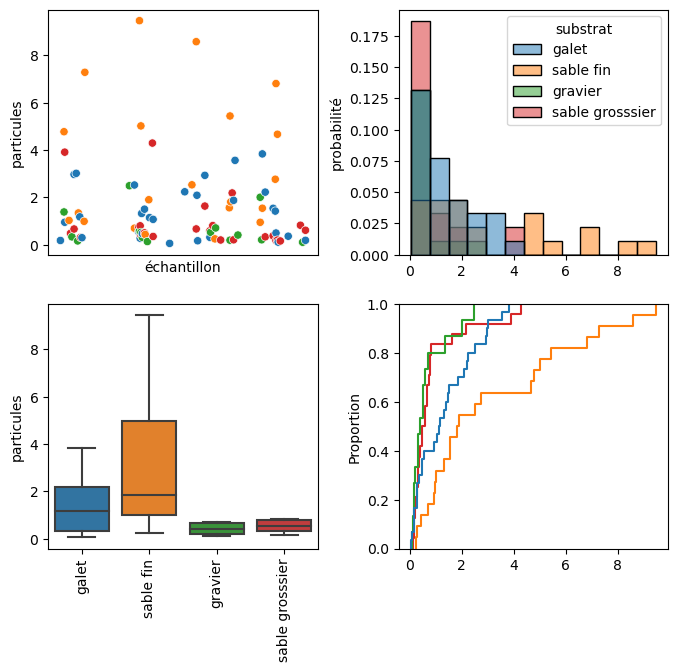

In [4]:
attribute_summary_grid(event_total, vals, voi, labels=labels)

### Les plages substrat = sable fin

In [5]:
md(', '.join(work_data[work_data.substrat.isin([1])].Plage.unique()))

Baby Plage, Bouveret, Excenevex, Préverenges, Rolle, Vidy, Grangettes

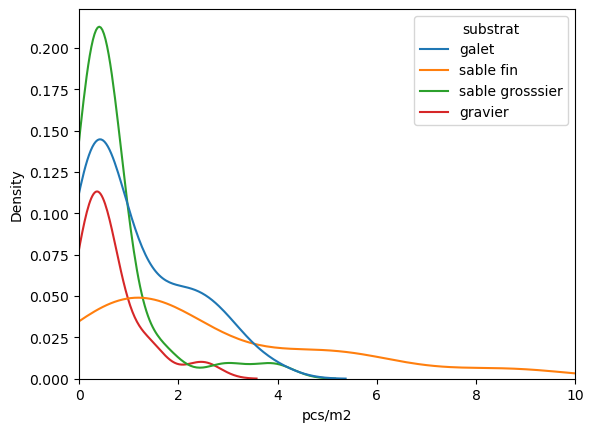

In [6]:
fig, ax = plt.subplots()
data = work_data.groupby(groupbys, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 10)
plt.show()

## Frequentation

In [7]:
# ananlysis of frequentation
voi = "frequentation"
vals = "pcs/m2"
groupbys = ['echantillon', voi]
labels = frequentation_name


event_total = work_data.groupby(["echantillon", "Plage","date", voi], as_index=False)[vals].sum()


substrat_summary = attribute_summary(event_total, vals, voi, columns=column_display, labels=labels)
substrat_summary

,n échantillons,moyenne,écart type,min,25%,50%,75%,max
faible,15,0.37,0.16,0,0.25,0.38,0.49,0
moyenne,28,1.87,2.06,0,0.34,1.05,2.62,8
élévée,55,1.53,1.61,0,0.64,0.94,1.89,8


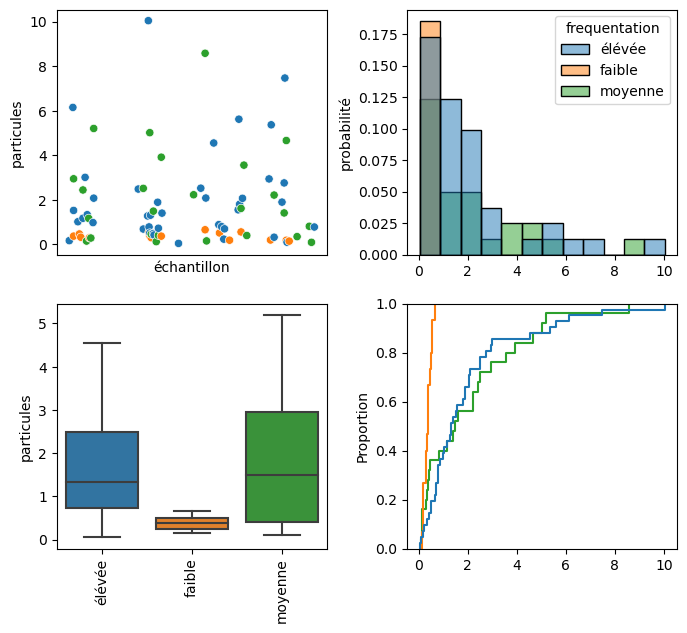

In [8]:
attribute_summary_grid(event_total, vals, voi, labels=labels)

### Les plages fréquentation = moyenne

In [9]:
md(', '.join(work_data[work_data.frequentation.isin([2])].Plage.unique()))

Aubonne, Lugrin, Saint-Disdille, Grangettes, Anthy, Gland, Pichette

### Les plages fréquentation = élevée

In [10]:
md(', '.join(work_data[work_data.frequentation.isin([3])].Plage.unique()))

Amphion, Baby Plage, Bouveret, Clarens, Excenevex, Préverenges, Rolle, Savonnière, Vidy, Tougues, Versoix, Port Choiseul, Hermance, Lutry

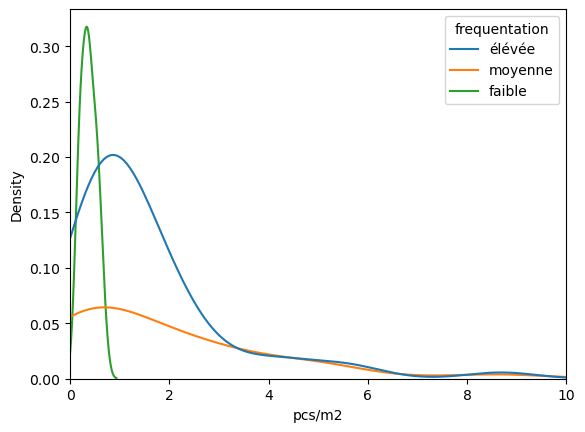

In [11]:
fig, ax = plt.subplots()

data = work_data.groupby(groupbys, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 10)
plt.show()

## Situation

In [12]:
# ananlysis of situation
voi = "situation"
vals = "pcs/m2"
groupby = ['echantillon', voi]
labels = situation_name

event_total = work_data.groupby(["echantillon", "Plage","date", voi], as_index=False)[vals].sum()


substrat_summary = attribute_summary(event_total, vals, voi, columns=column_display, labels=labels)
substrat_summary

,n échantillons,moyenne,écart type,min,25%,50%,75%,max
campagne,67,1.59,1.94,0,0.36,0.70,2.15,8
urbain,31,1.14,0.93,0,0.57,0.94,1.47,4


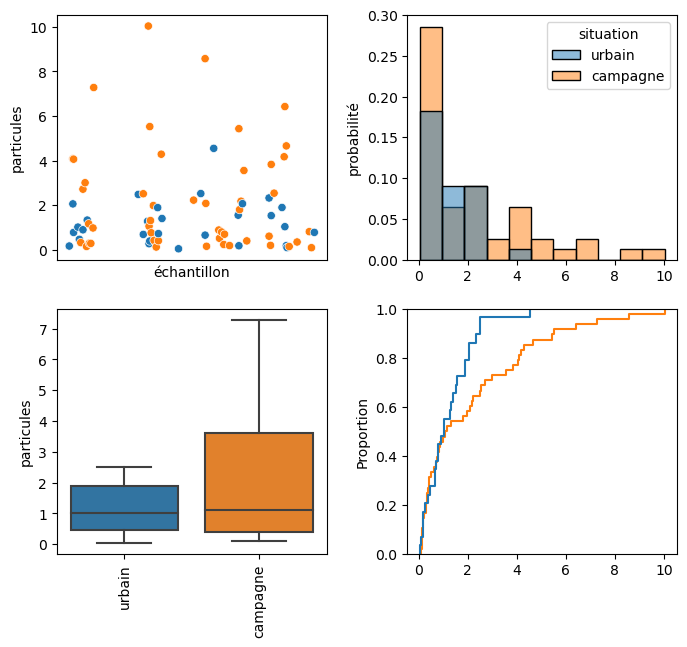

In [13]:
attribute_summary_grid(event_total, vals, voi, labels=labels)

### Les plages situation = campagne

In [14]:
md(', '.join(work_data[work_data.situation.isin([1])].Plage.unique()))

Amphion, Aubonne, Bouveret, Excenevex, Lugrin, Préverenges, Saint-Disdille, Savonnière, Grangettes, Tougues, Versoix, Tolochenaz, Anthy, Crans, Gland, Cully, Pichette

### Les plages situation = urbain

In [15]:
md(', '.join(work_data[work_data.situation.isin([2])].Plage.unique()))

Baby Plage, Clarens, Rolle, Vidy, Port Choiseul, Hermance, Lutry, Meillerie

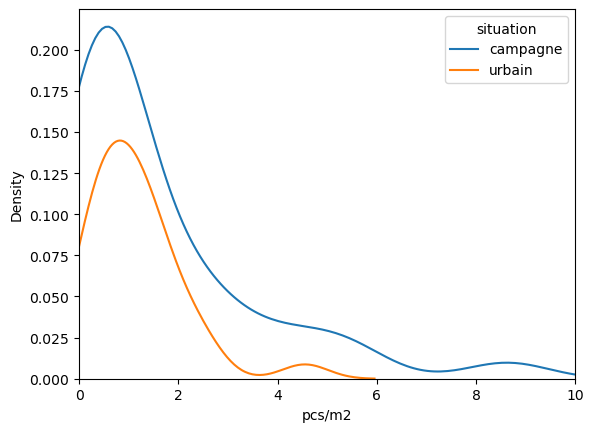

In [16]:
fig, ax = plt.subplots()

data = work_data.groupby(groupby, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: situation_name[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 10)
plt.show()

## Distance

In [17]:
# ananlysis of distance
voi = "distance"
vals = "pcs/m2"
groupby = ['echantillon', voi]
labels = name_the_distance

event_total = work_data.groupby(["echantillon", "Plage","date", voi], as_index=False)[vals].sum()


substrat_summary = attribute_summary(event_total, vals, voi, columns=column_display, labels=labels)
substrat_summary

,n échantillons,moyenne,écart type,min,25%,50%,75%,max
100 - 500m,44,1.84,2.04,0,0.67,1.11,1.94,8
500 - 1000m,7,0.43,0.15,0,0.38,0.40,0.52,0
< 100m,39,1.42,1.40,0,0.38,0.78,2.15,5
> 1000m,8,0.32,0.14,0,0.21,0.28,0.43,0


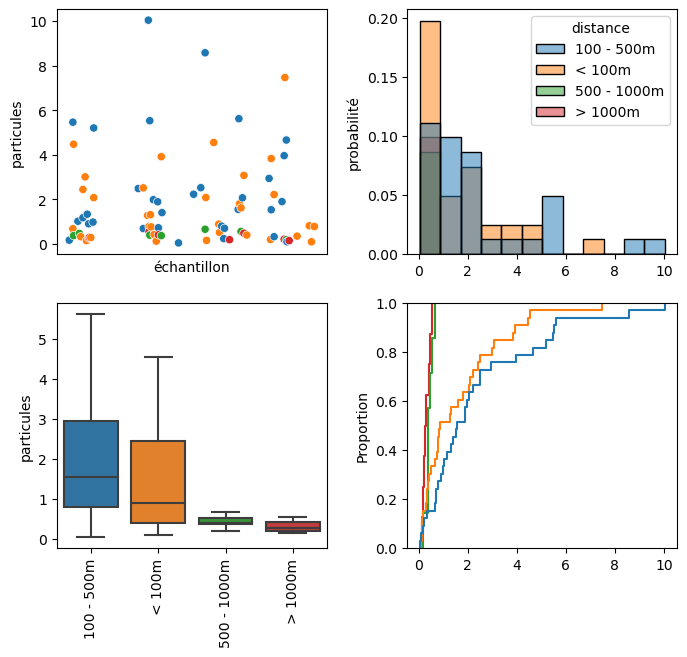

In [18]:
attribute_summary_grid(event_total, vals, voi, labels=labels)

### Les plages distance = 100 - 500m 

In [19]:
md(', '.join(work_data[work_data.distance.isin([2])].Plage.unique()))

Baby Plage, Bouveret, Lugrin, Préverenges, Vidy, Grangettes, Tougues, Versoix, Port Choiseul, Hermance, Lutry

### Les plages distance = < 100m  

In [20]:
md(', '.join(work_data[work_data.distance.isin([1])].Plage.unique()))

Amphion, Clarens, Excenevex, Rolle, Saint-Disdille, Savonnière, Anthy, Gland, Cully, Pichette

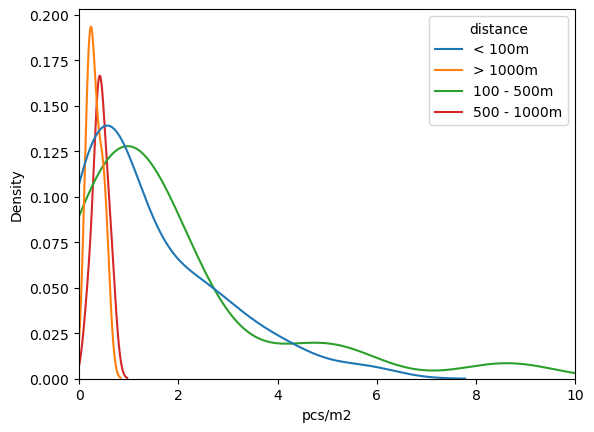

In [21]:
fig, ax = plt.subplots()

data = work_data.groupby(groupby, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 10)
plt.show()

## Orientation

In [22]:
# ananlysis of substrat
voi = "orientation"
vals = "pcs/m2"
groupby = ['echantillon', voi]

event_total = work_data.groupby(["echantillon", "Plage","date", voi], as_index=False)[vals].sum()
# data[voi] = data[voi].apply(lambda x: situation_name[x])

data_summary = event_total.groupby(voi, as_index=False)[vals].describe()
data_summary[['count', 'max', 'min']] = data_summary[['count', 'max', 'min']].astype('int')
data_summary.rename(columns=column_display, inplace=True)
data_summary.set_index("orientation", inplace=True, drop=True)
data_summary.index.name = None

select_values = data_summary["moyenne"] > 1.45
test_one = data_summary.loc[select_values].index

select_values = data_summary["50%"] > .78
test_two = data_summary.loc[select_values].index

d_sum = data_summary.style.set_table_styles(table_css_styles).format(precision=2)
d_sum = d_sum.set_properties(subset = pd.IndexSlice[test_one,["moyenne"]], **a_property)

d_sum.set_properties(subset = pd.IndexSlice[test_two,["50%"]], **a_property)

,n échantillons,moyenne,écart type,min,25%,50%,75%,max
E,4,2.32,1.38,0,1.42,2.28,3.19,3
ESE,4,0.60,0.08,0,0.56,0.59,0.64,0
N,8,1.50,1.17,0,0.45,1.44,2.46,3
NE,12,2.15,1.53,0,1.36,1.94,2.62,5
NNE,8,1.26,0.49,0,0.93,1.11,1.51,2
NNO,4,0.32,0.13,0,0.26,0.32,0.38,0
NO,12,2.35,2.77,0,0.51,0.77,4.75,8
ONO,8,2.56,3.18,0,0.37,0.68,4.42,8
OSO,4,0.26,0.31,0,0.09,0.14,0.31,0
SE,4,0.30,0.18,0,0.18,0.25,0.36,0
